In [19]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import numpy as np
import re

import seaborn as sns

In [20]:
data = pd.read_csv('../data/train.csv')

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
data = data[data['Y'] != 90]
data = data[data['Category'] != 'NONE']

print(len(data['Category'].unique()))

standard_scaler = StandardScaler()
x = np.asarray(data['X']).reshape((-1, 1))
y = np.asarray(data['Y']).reshape((-1, 1))
data['X'] = StandardScaler().fit_transform(x)
data['Y'] = StandardScaler().fit_transform(y)

sns.set(rc={'figure.figsize': (20, 15)})
sns.scatterplot(data, x='Y', y='X', hue='Category')


39


C:\Users\Lea Keller\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret value `X` for parameter `y`

In [29]:
data = pd.read_csv('../data/train.csv')

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
data = data[data['Y'] != 90]

y_train = data['Category']

# The description and category are not part of the test data, therefore we cannot use them for training.
# And we need to drop the resolution variable since it is our target variable and also not part of the test data.
x_train = data.drop(['Descript', 'Category', 'Resolution'], axis=1)

# TODO: Extract this into a function. ###
# Split the date into its subcomponents
x_train[['year', 'month', 'day', 'hour', 'minute']] = x_train.Dates.str.extract(
    '(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2}) (?P<hour>\d{2}):(?P<minute>\d{2})')

x_train["federal_holiday"] = "None"
x_train.loc[x_train['Dates'].str.match('\d{4}-01-01'), 'federal_holiday'] = 'new_year'
x_train.loc[x_train['Dates'].str.match('\d{4}-07-04'), 'federal_holiday'] = 'independence_day'
x_train.loc[x_train['Dates'].str.match('\d{4}-11-24'), 'federal_holiday'] = 'thanksgiving'
x_train.loc[x_train['Dates'].str.match('\d{4}-12-25'), 'federal_holiday'] = 'christmas_day'
x_train.loc[x_train['Dates'].str.match('\d{4}-12-26'), 'federal_holiday'] = 'christmas_day'
x_train.loc[x_train['Dates'].str.match('\d{4}-12-31'), 'federal_holiday'] = 'new_year'

x_train.drop(['Dates'], inplace=True, axis=1)

# Convert the date numbers into actual integers
x_train = x_train.astype({
    'year': 'float64',
    'month': 'float64',
    'day': 'float64',
    'hour': 'float64',
    'minute': 'float64',
})

x_train.loc[x_train['hour']<=7,'isday']= 0
x_train.loc[x_train['hour']>7,'isday']= 1
x_train.loc[x_train['hour']>19,'isday']= 0

x_train["IsWeekend"]= 0
x_train.loc[x_train['DayOfWeek'] == 'Sunday', 'IsWeekend'] = 1
x_train.loc[x_train['DayOfWeek'] == 'Saturday', 'IsWeekend'] = 1

# One-Hot encoding for the DayOfTheWeek
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['DayOfWeek', 'PdDistrict']),
    (StandardScaler(), ['X', 'Y', 'year', 'month', 'day', 'hour', 'minute']),
    remainder='passthrough'
)

x_train_transformed = column_transformer.fit_transform(x_train)
x_train = pd.DataFrame(data=x_train_transformed, columns=column_transformer.get_feature_names_out())

x_train = x_train.rename(columns={element: re.sub(r'^(.+)__', '', element) for element in x_train.columns.tolist()})

x_train.to_csv('../data/x_train_cleaned.csv', index=False)
y_train.to_csv('../data/y_train_cleaned.csv', index=False)

x_train

,DayOfWeek,PdDistrict,Address,X,Y,year,month,day,hour,minute,federal_holiday
0,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015.0,5.0,13.0,23.0,53.0,None
1,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015.0,5.0,13.0,23.0,53.0,None
2,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015.0,5.0,13.0,23.0,33.0,None
3,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,2015.0,5.0,13.0,23.0,30.0,None
4,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,2015.0,5.0,13.0,23.0,30.0,None
...,...,...,...,...,...,...,...,...,...,...,...
878044,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003.0,1.0,6.0,0.0,15.0,None
878045,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948,2003.0,1.0,6.0,0.0,1.0,None
878046,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266,2003.0,1.0,6.0,0.0,1.0,None
878047,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003.0,1.0,6.0,0.0,1.0,None


2.2181886278116716


<AxesSubplot: xlabel='Y', ylabel='X'>

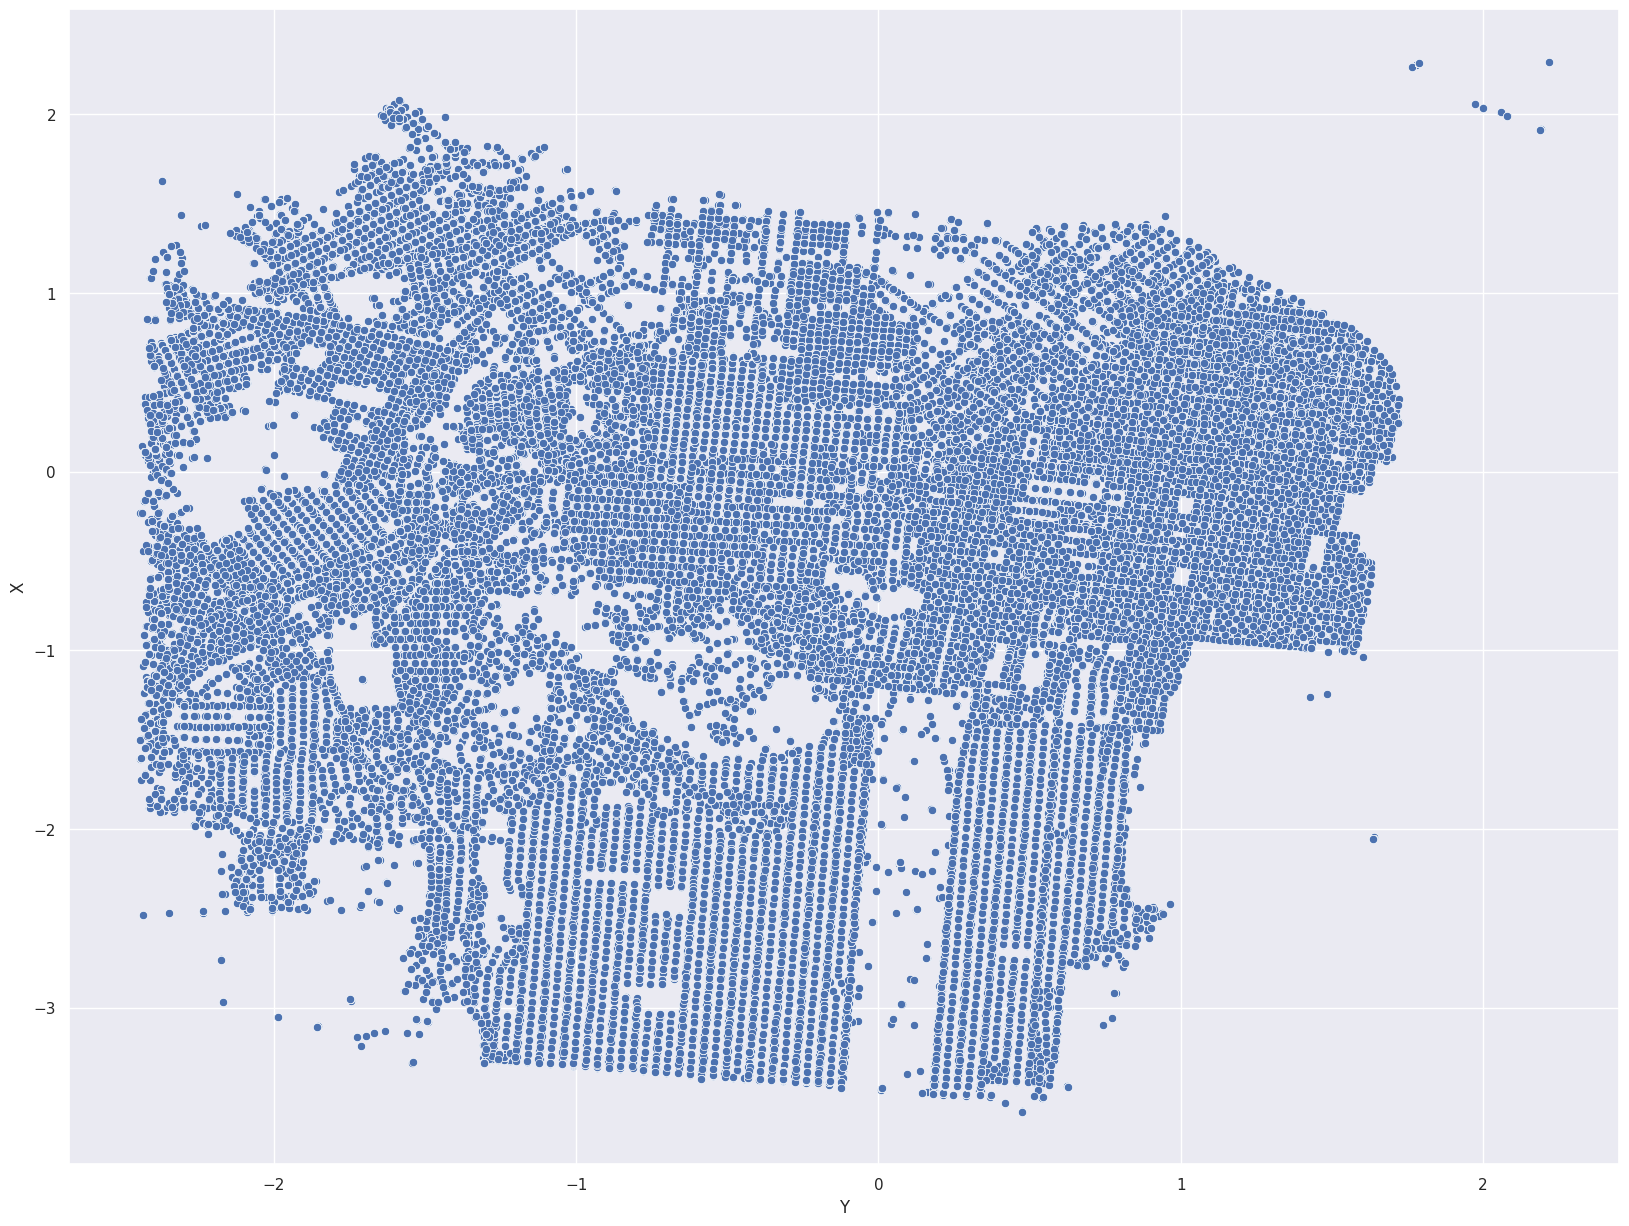

In [6]:
data = pd.read_csv('../data/test.csv')

# TODO: What are we supposed to do to get predictions for the data sets that do not have proper coordinates?
data = data[data['Y'] != 90]

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
standard_scaler = StandardScaler()
x = np.asarray(data['X']).reshape((-1, 1))
y = np.asarray(data['Y']).reshape((-1, 1))
data['X'] = StandardScaler().fit_transform(x)
data['Y'] = StandardScaler().fit_transform(y)

print(data['Y'].max())

sns.set(rc={'figure.figsize': (20, 15)})
sns.scatterplot(data, x='Y', y='X')

In [8]:
data = pd.read_csv('../data/test.csv')

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
# data = data[data['Y'] != 90]


# The description and category are not part of the test data, therefore we cannot use them for training.
# And we need to drop the resolution variable since it is our target variable and also not part of the test data.

# TODO: Extract this into a function. ###
# Split the date into its subcomponents
data[['year', 'month', 'day', 'hour', 'minute']] = data.Dates.str.extract(
    '(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2}) (?P<hour>\d{2}):(?P<minute>\d{2})')

# data["federal_holiday"] = "None"
# data.loc[data['Dates'].str.match('\d{4}-01-01'), 'federal_holiday'] = 'new_year'
# data.loc[data['Dates'].str.match('\d{4}-07-04'), 'federal_holiday'] = 'independence_day'
# data.loc[data['Dates'].str.match('\d{4}-11-24'), 'federal_holiday'] = 'thanksgiving'
# data.loc[data['Dates'].str.match('\d{4}-12-25'), 'federal_holiday'] = 'christmas_day'
# data.loc[data['Dates'].str.match('\d{4}-12-26'), 'federal_holiday'] = 'christmas_day'
# data.loc[data['Dates'].str.match('\d{4}-12-31'), 'federal_holiday'] = 'new_year'

data.drop(['Dates'], inplace=True, axis=1)

# Convert the date numbers into actual integers
data = data.astype({
    'year': 'float64',
    'month': 'float64',
    'day': 'float64',
    'hour': 'float64',
    'minute': 'float64',
})

# One-Hot encoding for the DayOfTheWeek
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['DayOfWeek', 'PdDistrict']),
    (StandardScaler(), ['X', 'Y', 'year', 'month', 'day', 'hour', 'minute']),
    remainder='passthrough'
)

data_transformed = column_transformer.fit_transform(data)
data = pd.DataFrame(data=data_transformed, columns=column_transformer.get_feature_names_out())

data = data.rename(columns={element: re.sub(r'^(.+)__', '', element) for element in data.columns.tolist()})

data.to_csv('../data/test_cleaned.csv', index=False)

data

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,PdDistrict_TENDERLOIN,X,Y,year,month,day,hour,minute,Id,Address
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.7457,-0.07513,1.730764,-0.379014,-0.63667,1.464267,2.087371,0,2000 Block of THOMAS AV
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.005982,-0.080531,1.730764,-0.379014,-0.63667,1.464267,1.657505,1,3RD ST / REVERE AV
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.106786,0.042772,1.730764,-0.379014,-0.63667,1.464267,1.603771,2,2000 Block of GOUGH ST
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.474449,-0.103262,1.730764,-0.379014,-0.63667,1.464267,1.335105,3,4700 Block of MISSION ST
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.474449,-0.103262,1.730764,-0.379014,-0.63667,1.464267,1.335105,4,4700 Block of MISSION ST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.442465,-0.040198,-1.567889,-1.532728,-1.650781,-2.042421,-1.029158,884257,2600 Block of BRYANT ST
884258,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,-0.085497,0.043739,-1.567889,-1.532728,-1.650781,-2.042421,-1.029158,884258,1900 Block of WASHINGTON ST
884259,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,-0.733421,-0.122521,-1.567889,-1.532728,-1.650781,-2.042421,-1.029158,884259,5500 Block of MISSION ST
884260,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.139232,-0.065996,-1.567889,-1.532728,-1.650781,-2.042421,-1.029158,884260,1500 Block of HUDSON AV
